Marta Españó López (s1103330)


The main additions to this notebook are marked in the title with: "(newly added)"

# Inspiration

Baseline notebook: https://github.com/mkosaka1/Speech_Emotion_Recognition/blob/master/1-Initial_CNN_Model.ipynb

Dataset: https://github.com/CheyneyComputerScience/CREMA-D

# Load Packages

In [1]:
%%capture
!pip install resampy
!pip install tensorflow
!pip install keras

In [2]:
# IMPORT NECESSARY LIBRARIES
import resampy
import librosa
import soundfile as sf
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
from IPython.display import Audio
import numpy as np
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
from sklearn.metrics import confusion_matrix
import IPython.display as ipd  # To play sound in the notebook
import os # interface with underlying OS that python is running on
import sys
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization, Dense
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report

# Data Preprocessing

## Labeling Audio Files

In [3]:
!git lfs clone 'https://github.com/CheyneyComputerScience/CREMA-D.git'

          with new flags from 'git clone'

'git clone' has been updated in upstream Git to have comparable
speeds to 'git lfs clone'.
Cloning into 'CREMA-D'...
remote: Enumerating objects: 22501, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 22501 (delta 22), reused 57 (delta 13), pack-reused 22428
Receiving objects: 100% (22501/22501), 14.82 MiB | 15.58 MiB/s, done.
Resolving deltas: 100% (75/75), done.
Updating files: 100% (22342/22342), done.


In [4]:
# CREATE DIRECTORY OF AUDIO FILES 
audio = "CREMA-D/AudioWAV"
actor_folders = os.listdir(audio) #list files in audio directory
actor_folders.sort()
audio1 = "CREMA-D/AudioMP3"
actor_folders1 = os.listdir(audio1) #list files in audio directory
actor_folders1.sort()

In [5]:
%%capture
# CREATE FUNCTION TO EXTRACT EMOTION NUMBER, ACTOR AND GENDER LABEL
df = pd.DataFrame(columns=('emotion','actor','path'))
races = pd.DataFrame(columns=('actor','race'))
for i in actor_folders:
  actor=i[0:4]
  file_name='CREMA-D/AudioWAV/'+i
  emotion=i[9:12]
  df = df.append({'emotion':emotion, 'path':file_name, 'actor':str(actor)}, ignore_index=1)
r = pd.read_csv('CREMA-D/VideoDemographics.csv')
for a in range(len(r)):
  actor=r['ActorID'][a]
  race=r['Race'][a]
  if race != 'Unknown': #getting rid of actor with unknown race (actor 1047)
    races = races.append({'actor':str(actor),'race':race}, ignore_index=1)
audio_df = pd.merge(df,races)

## EDA (newly added)

In [6]:
audio_df

,emotion,actor,path,race
0,ANG,1001,CREMA-D/AudioWAV/1001_DFA_ANG_XX.wav,Caucasian
1,DIS,1001,CREMA-D/AudioWAV/1001_DFA_DIS_XX.wav,Caucasian
2,FEA,1001,CREMA-D/AudioWAV/1001_DFA_FEA_XX.wav,Caucasian
3,HAP,1001,CREMA-D/AudioWAV/1001_DFA_HAP_XX.wav,Caucasian
4,NEU,1001,CREMA-D/AudioWAV/1001_DFA_NEU_XX.wav,Caucasian
...,...,...,...,...
7355,DIS,1091,CREMA-D/AudioWAV/1091_WSI_DIS_XX.wav,Asian
7356,FEA,1091,CREMA-D/AudioWAV/1091_WSI_FEA_XX.wav,Asian
7357,HAP,1091,CREMA-D/AudioWAV/1091_WSI_HAP_XX.wav,Asian
7358,NEU,1091,CREMA-D/AudioWAV/1091_WSI_NEU_XX.wav,Asian


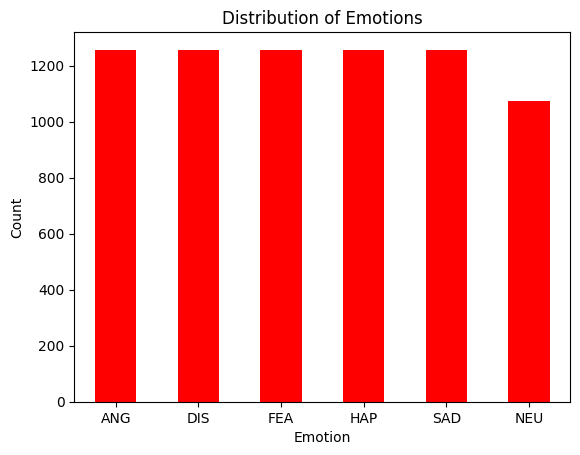

In [7]:
# LOOK AT DISTRIBUTION OF EMOTION CLASSES
audio_df.emotion.value_counts().plot(kind='bar', color='red')
plt.xticks(rotation=0)
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Distribution of Emotions')
plt.savefig('Emotion_distribution.png')

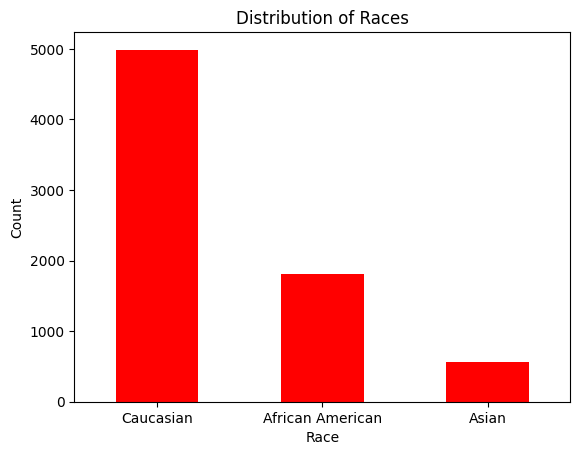

In [8]:
# LOOK AT DISTRIBUTION OF RACE CLASS BEFORE DATA AUGMENTATION 
audio_df.race.value_counts().plot(kind='bar', color='red')
plt.xticks(rotation=0)
plt.xlabel('Race')
plt.ylabel('Count')
plt.title('Distribution of Races')
plt.savefig('Race_distribution_pre.png')

# Data Augmentation (newly added)

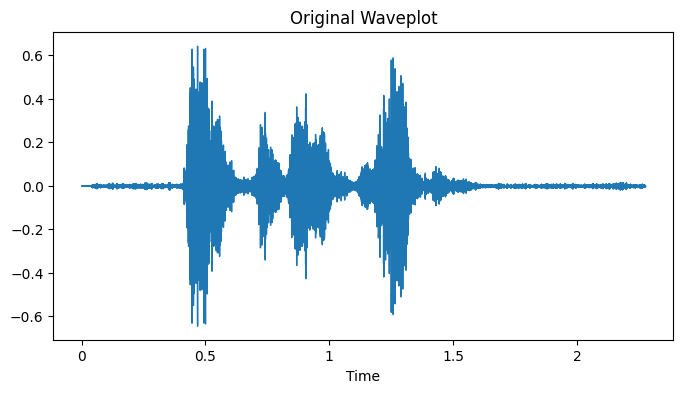

In [9]:
#Load and visualize first sample
x, sr = librosa.load('CREMA-D/AudioWAV/1001_DFA_ANG_XX.wav')
plt.figure(figsize=(8, 4))
librosa.display.waveshow(x, sr=sr)
plt.title('Original Waveplot')
plt.savefig('Waveplot_before.png')
sf.write('testt.wav', x, sr)
Audio(data=x, rate=sr)

In [10]:
def add_noise(audio, noise):
  '''
  Adds white noise to an audio sample.
  '''
  x, sr = librosa.load(audio)
  n = np.random.randn(len(x))*noise
  xn = x+n
  return xn, sr

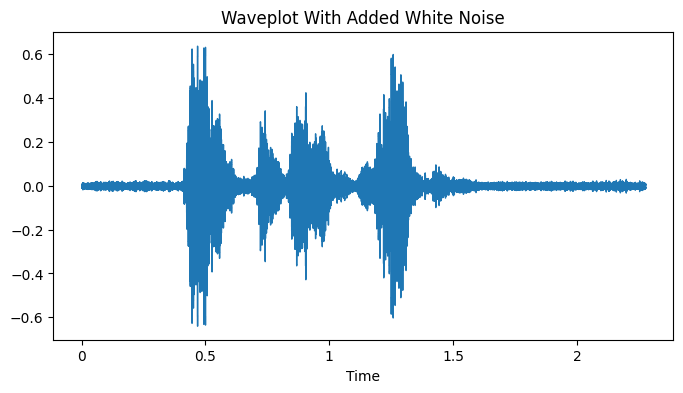

In [11]:
#Visualize first sample with added noise
x ='CREMA-D/AudioWAV/1001_DFA_ANG_XX.wav'
xn, sr = add_noise(x, 0.005)
plt.figure(figsize=(8, 4))
librosa.display.waveshow(xn, sr=sr)
plt.title('Waveplot With Added White Noise')
plt.savefig('Waveplot_after.png')

sf.write('testt.wav', xn, sr)
Audio(data=xn, rate=sr)

In [12]:
#counting number of samples per race
race_count = audio_df['race'].value_counts()
race_count

Caucasian           4988
African American    1804
Asian                568
Name: race, dtype: int64

In [13]:
#balancing underrepresented classes
def balance_dataset(dataframe, class1, class2, noise):
  '''
  Given two classes, it creates as many new noisy samples from the same 
  underrepresented class(2) until it reaches the same number of samples as 
  the overrepresented class(1).
  '''
  max_count = race_count[class1] #overrepresented
  count = race_count[class2] #underrepresented
  balance = True
  i=0
  while i < max_count:
    nsample = np.random.randint(0, len(dataframe))
    sample = dataframe['path'][nsample]
    if balance:
      if count >= max_count:
        balance = False
      if dataframe['race'][nsample] == class2:
        xn, sr = add_noise(sample, noise)
        save_path = './CREMA-D/AudioWAV'
        save_name = sample[17:32]+'_'+str(i)+'.wav'
        file_name = os.path.join(save_path, save_name)
        sf.write(file_name, xn, sr)
        count+=1
        print('Creating noisy sample: '+str(nsample))
        i+=1
      else:
        continue
    else:
      print('Dataset balanced!')
      break

In [14]:
#balance
noise = 0.005
class1 = 'Caucasian' #overrepresented
lclass2 = ['Asian', 'African American'] #underrepresetned 

for class2 in lclass2:
  balance_dataset(audio_df, class1, class2, noise)

Streaming output truncated to the last 5000 lines.
Creating noisy sample: 6464
Creating noisy sample: 5743
Creating noisy sample: 1514
Creating noisy sample: 5760
Creating noisy sample: 1500
Creating noisy sample: 5770
Creating noisy sample: 6519
Creating noisy sample: 6795
Creating noisy sample: 6521
Creating noisy sample: 5784
Creating noisy sample: 6828
Creating noisy sample: 1529
Creating noisy sample: 6522
Creating noisy sample: 7329
Creating noisy sample: 5762
Creating noisy sample: 6790
Creating noisy sample: 7234
Creating noisy sample: 6475
Creating noisy sample: 1468
Creating noisy sample: 1494
Creating noisy sample: 6857
Creating noisy sample: 6822
Creating noisy sample: 6539
Creating noisy sample: 7234
Creating noisy sample: 7327
Creating noisy sample: 6470
Creating noisy sample: 5767
Creating noisy sample: 1483
Creating noisy sample: 7296
Creating noisy sample: 7262
Creating noisy sample: 6473
Creating noisy sample: 5777
Creating noisy sample: 7278
Creating noisy sample: 57



## Re-labeling
After balancing the dataset we need to run again the previous section ("Labeling Audio Files") to include the new samples into the "audio_df" dataframe. Copied the said section bellow to avoid scrolling up and down.





In [15]:
%%capture
# CREATE DIRECTORY OF AUDIO FILES 
audio = "CREMA-D/AudioWAV"
actor_folders = os.listdir(audio) #list files in audio directory
actor_folders.sort()
audio1 = "CREMA-D/AudioMP3"
actor_folders1 = os.listdir(audio1) #list files in audio directory
actor_folders1.sort()

# CREATE FUNCTION TO EXTRACT EMOTION NUMBER, ACTOR AND GENDER LABEL
df = pd.DataFrame(columns=('emotion','actor','path'))
races = pd.DataFrame(columns=('actor','race'))
for i in actor_folders:
  actor=i[0:4]
  file_name='CREMA-D/AudioWAV/'+i
  emotion=i[9:12]
  df = df.append({'emotion':emotion, 'path':file_name, 'actor':str(actor)}, ignore_index=1)
r = pd.read_csv('CREMA-D/VideoDemographics.csv')
for a in range(len(r)):
  actor=r['ActorID'][a]
  race=r['Race'][a]
  if race != 'Unknown': #getting rid of actor with unknown race (actor 1047)
    races = races.append({'actor':str(actor),'race':race}, ignore_index=1)
audio_df = pd.merge(df,races)

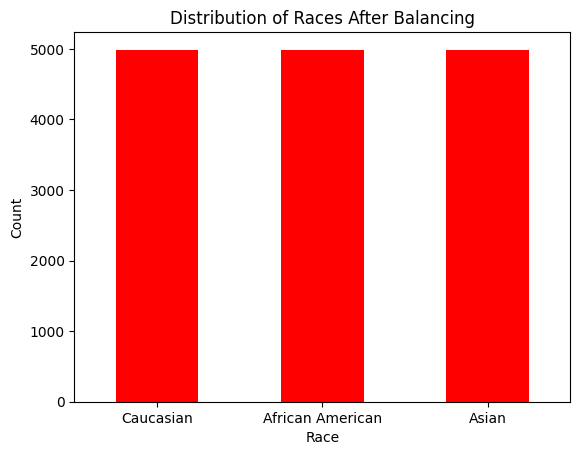

In [16]:
# LOOK AT DISTRIBUTION OF RACE CLASS AFTER DATA AUGMENTATION 
audio_df.race.value_counts().plot(kind='bar', color='red')
plt.xticks(rotation=0)
plt.xlabel('Race')
plt.ylabel('Count')
plt.title('Distribution of Races After Balancing')
plt.savefig('Race_distribution_post.png')



---



# Feature Extraction

In [17]:
# ITERATE OVER ALL AUDIO FILES AND EXTRACT LOG MEL SPECTROGRAM MEAN VALUES INTO DF FOR MODELING 
def mel_spectrogram(dataframe):
  df = pd.DataFrame(columns=['mel_spectrogram'])
  counter = 0
  for index,path in enumerate(dataframe.path):
      X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
      
      #get the mel-scaled spectrogram (ransform both the y-axis (frequency) to log scale, and the “color” axis (amplitude) to Decibels, which is kinda the log scale of amplitudes.)
      spectrogram = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000) 
      db_spec = librosa.power_to_db(spectrogram)
      #temporally average spectrogram
      log_spectrogram = np.mean(db_spec, axis = 0)
          
      # Mel-frequency cepstral coefficients (MFCCs)
  #     mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
  #     mfcc=np.mean(mfcc,axis=0)
      
      # compute chroma energy (pertains to 12 different pitch classes)
  #     chroma = librosa.feature.chroma_stft(y=X, sr=sample_rate)
  #     chroma = np.mean(chroma, axis = 0)

      # compute spectral contrast
  #     contrast = librosa.feature.spectral_contrast(y=X, sr=sample_rate)
  #     contrast = np.mean(contrast, axis= 0)

      # compute zero-crossing-rate (zcr:the zcr is the rate of sign changes along a signal i.e.m the rate at 
  #     which the signal changes from positive to negative or back - separation of voiced andunvoiced speech.)
  #     zcr = librosa.feature.zero_crossing_rate(y=X)
  #     zcr = np.mean(zcr, axis= 0)
      
      df.loc[counter] = [log_spectrogram]
      counter=counter+1
  return df   

In [18]:
df = mel_spectrogram(audio_df)
print(len(df))
df.head()

14964


,mel_spectrogram
0,"[-8.611901, -8.497661, -11.3269615, -12.500107..."
1,"[-43.943283, -42.09897, -38.89283, -26.912682,..."
2,"[-42.535862, -40.42614, -39.694233, -40.159477..."
3,"[-23.501884, -19.445797, -18.871653, -18.38984..."
4,"[-25.88915, -24.836338, -27.5353, -29.413418, ..."


In [19]:
# TURN ARRAY INTO LIST AND JOIN WITH AUDIO_DF TO GET CORRESPONDING EMOTION LABELS
df_combined = pd.concat([audio_df,pd.DataFrame(df['mel_spectrogram'].values.tolist())],axis=1)
df_combined = df_combined.fillna(0)

In [20]:
# DROP PATH COLUMN FOR MODELING
df_combined.drop(columns='path',inplace=True)

In [21]:
# CHECK TOP 5 ROWS
df_combined.head()

,emotion,actor,race,0,1,2,3,4,5,6,...,249,250,251,252,253,254,255,256,257,258
0,ANG,1001,Caucasian,-8.611901,-8.497661,-11.326962,-12.500107,-14.003399,-15.888887,-18.942160,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,DIS,1001,Caucasian,-43.943283,-42.098969,-38.892830,-26.912682,-21.941996,-18.847887,-15.480346,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,FEA,1001,Caucasian,-42.535862,-40.426140,-39.694233,-40.159477,-41.028137,-37.574142,-25.677588,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,HAP,1001,Caucasian,-23.501884,-19.445797,-18.871653,-18.389839,-17.496157,-18.229759,-20.004917,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,NEU,1001,Caucasian,-25.889151,-24.836338,-27.535299,-29.413418,-30.384449,-32.063469,-31.157967,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Prepping Data for Modeling

In [22]:
# TRAIN TEST SPLIT DATA
train,test = train_test_split(df_combined, test_size=0.2, random_state=0,
                               stratify=df_combined[['emotion','race','actor']])

In [23]:
X_train = train.iloc[:, 3:]
y_train = train.iloc[:,:1] #y_train = train.iloc[:,:2].drop(columns=['gender']) así es como es en el código original
print(X_train.shape)

(11971, 259)


In [24]:
X_test = test.iloc[:,3:]
y_test = test.iloc[:,:1] #y_test = test.iloc[:,:2].drop(columns=['gender'])
print(X_test.shape)

(2993, 259)


# Data Preprocessing

In [25]:
# NORMALIZE DATA
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

In [26]:
# TURN DATA INTO ARRAYS FOR KERAS
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [27]:
# ONE HOT ENCODE THE TARGET
# CNN REQUIRES INPUT AND OUTPUT ARE NUMBERS
lb = LabelEncoder()
#y_train = np.ravel(y_train)
#y_test = np.ravel(y_test)
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))

print(y_test[0:10])

[[0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]]


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [28]:
print(lb.classes_)

['ANG' 'DIS' 'FEA' 'HAP' 'NEU' 'SAD']


## Base Model

In [29]:
X_train.shape

(11971, 259)

In [30]:
X_test.shape

(2993, 259)

In [31]:
import numpy as np
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(X_train, y_train)
DummyClassifier(strategy='stratified')
dummy_clf.predict(X_test)
dummy_clf.score(X_test, y_test)


0.06515202138322754

In [32]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
clf.predict(X_test)
clf.score(X_test, y_test)


0.552956899432008

## Initial Model

In [33]:
# RESHAPE DATA TO INCLUDE 3D TENSOR 
X_train = X_train[:,:,np.newaxis]
X_test = X_test[:,:,np.newaxis]

X_train.shape

(11971, 259, 1)

In [34]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model

#BUILD 1D CNN LAYERS
def cnn_model(X_train, optimizer):
  model = tf.keras.Sequential()
  model.add(layers.Conv1D(64, kernel_size=(10), activation='relu', input_shape=(X_train.shape[1],1)))
  model.add(layers.Conv1D(128, kernel_size=(10),activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
  model.add(layers.MaxPooling1D(pool_size=(8)))
  model.add(layers.Dropout(0.4))
  model.add(layers.Conv1D(128, kernel_size=(10),activation='relu'))
  model.add(layers.MaxPooling1D(pool_size=(8)))
  model.add(layers.Dropout(0.4))
  model.add(layers.Flatten())
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.Dropout(0.4))
  model.add(layers.Dense(6, activation='softmax'))  #I changed '8' by '6' bc in our project we have 6 classes not 8
  if optimizer=='Adam': opt = keras.optimizers.Adam(learning_rate=0.001)
  elif optimizer=='SGD': opt = keras.optimizers.SGD(learning_rate=0.001)
  model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
  model.summary()
  return model

model = cnn_model(X_train,'SGD')
opt = keras.optimizers.Adam(learning_rate=0.0001)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 250, 64)           704       
                                                                 
 conv1d_1 (Conv1D)           (None, 241, 128)          82048     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 30, 128)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 30, 128)           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 21, 128)           163968    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 2, 128)           0         
 1D)                                                    

In [35]:
#prev params (baseline):
#{'batch_size': 32, 'nb_epoch': 40, 'optimizer': 'SGD'}

#best params after grid search:
#{'batch_size': 36, 'nb_epoch': 75, 'optimizer': 'SGD'}

In [36]:
import tensorflow.keras as keras

# FIT MODEL AND USE CHECKPOINT TO SAVE BEST MODEL
checkpoint = ModelCheckpoint("best_initial_model.hdf5", monitor='val_accuracy', verbose=1,
    save_best_only=True, mode='max', period=1, save_weights_only=True)

model_history=model.fit(X_train, y_train, batch_size=36, epochs=75, validation_data=(X_test, y_test), callbacks=[checkpoint])

Epoch 1/75
333/333 [==============================] - ETA: 0s - loss: 2.6344 - accuracy: 0.1872
Epoch 1: val_accuracy improved from -inf to 0.23421, saving model to best_initial_model.hdf5
333/333 [==============================] - 63s 184ms/step - loss: 2.6344 - accuracy: 0.1872 - val_loss: 2.6072 - val_accuracy: 0.2342
Epoch 2/75
333/333 [==============================] - ETA: 0s - loss: 2.5947 - accuracy: 0.2152
Epoch 2: val_accuracy improved from 0.23421 to 0.27297, saving model to best_initial_model.hdf5
333/333 [==============================] - 63s 188ms/step - loss: 2.5947 - accuracy: 0.2152 - val_loss: 2.5710 - val_accuracy: 0.2730
Epoch 3/75
333/333 [==============================] - ETA: 0s - loss: 2.5571 - accuracy: 0.2417
Epoch 3: val_accuracy improved from 0.27297 to 0.28600, saving model to best_initial_model.hdf5
333/333 [==============================] - 59s 176ms/step - loss: 2.5571 - accuracy: 0.2417 - val_loss: 2.5344 - val_accuracy: 0.2860
Epoch 4/75
333/333 [=====

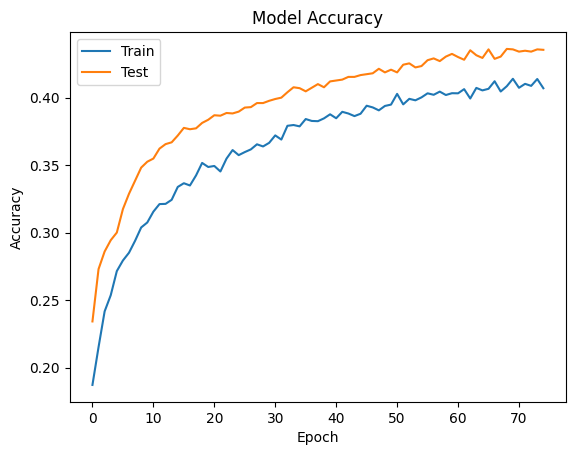

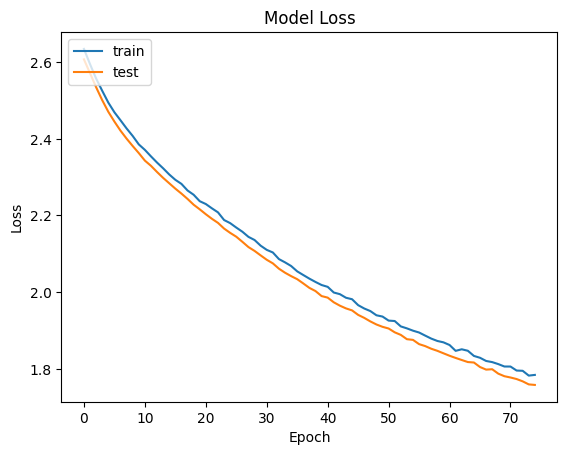

In [37]:
# PLOT MODEL HISTORY OF ACCURACY AND LOSS OVER EPOCHS
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('Initial_Model_Accuracy.png')
plt.show()
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('Initial_Model_loss.png')
plt.show()

## Post-Model Analysis
On test set.

In [38]:
# PRINT LOSS AND ACCURACY PERCENTAGE ON TEST SET
print("Loss of the model is - " , model.evaluate(X_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

94/94 [==============================] - 3s 36ms/step - loss: 1.7580 - accuracy: 0.4353
Loss of the model is -  1.7580488920211792
94/94 [==============================] - 3s 33ms/step - loss: 1.7580 - accuracy: 0.4353
Accuracy of the model is -  43.534913659095764 %


In [39]:
# PREDICTIONS
predictions = model.predict(X_test)
predictions = predictions.argmax(axis=1)
predictions = predictions.astype(int).flatten()
#lb = LabelEncoder()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions})

# ACTUAL LABELS
actual = y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'Actual Values': actual})

# COMBINE BOTH 
finaldf = actual.join(predictions)
finaldf[140:150]

94/94 [==============================] - 3s 32ms/step


,Actual Values,Predicted Values
140,ANG,ANG
141,HAP,ANG
142,ANG,HAP
143,HAP,HAP
144,DIS,DIS
145,HAP,HAP
146,FEA,SAD
147,SAD,HAP
148,ANG,ANG
149,HAP,HAP


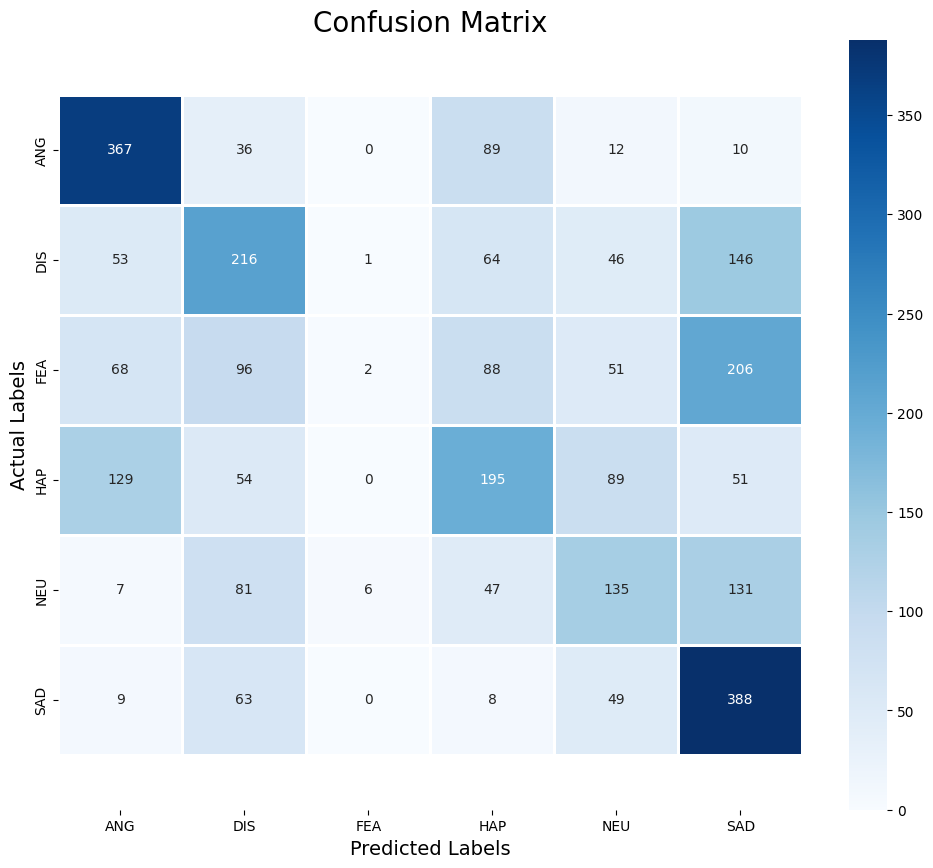

In [40]:
# CREATE CONFUSION MATRIX OF ACTUAL VS. PREDICTION 
cm = confusion_matrix(actual, predictions)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.savefig('Initial_Model_Confusion_Matrix.png')
plt.show()

In [41]:
print(classification_report(actual, predictions, target_names = ['ANG','DIS','FEA','HAP','NEU','SAD']))

              precision    recall  f1-score   support

         ANG       0.58      0.71      0.64       514
         DIS       0.40      0.41      0.40       526
         FEA       0.22      0.00      0.01       511
         HAP       0.40      0.38      0.39       518
         NEU       0.35      0.33      0.34       407
         SAD       0.42      0.75      0.54       517

    accuracy                           0.44      2993
   macro avg       0.39      0.43      0.39      2993
weighted avg       0.40      0.44      0.39      2993



## Post-model Per-race Analysis (newly added)

In [42]:
#add race to dataframe
finaldf1=finaldf
finaldf1['race']=test['race'].values
finaldf1[1:10]

,Actual Values,Predicted Values,race
1,ANG,ANG,Asian
2,HAP,SAD,Asian
3,DIS,DIS,Caucasian
4,SAD,SAD,Asian
5,FEA,SAD,Caucasian
6,DIS,DIS,Asian
7,ANG,ANG,Asian
8,DIS,DIS,Asian
9,SAD,SAD,Caucasian


In [43]:
#CORRECT AND INCORRECT PREDICITONS PER RACE
act=finaldf['Actual Values']
pred=finaldf['Predicted Values']
race=finaldf1['race']

dic={}
dic2={}
total=0
total2=0

for i, ele1 in enumerate(act):
  if ele1 == pred[i]: #correct preds
    if race[i] not in dic:
      dic[race[i]]=1
      total+=1
    else:
      dic[race[i]]+=1
      total+=1
  else: #incorrect preds
    if race[i] not in dic2:
      dic2[race[i]]=1
      total2+=1
    else:
      dic2[race[i]]+=1
      total2+=1

print(dic, total)
print(dic2, total2)
print()

#ACCURACY PER-RACE
total3=total+total2

print('CORRECT')
for k in dic.keys():
  res=0
  res=dic[k]/total
  print(k+': '+str(round(res,4)))

print('\n'+'INCORRECT')
for k in dic2.keys():
  res=0
  res=dic2[k]/total2
  print(k+': '+str(round(res,4)))

{'Asian': 488, 'Caucasian': 429, 'African American': 386} 1303
{'African American': 584, 'Asian': 508, 'Caucasian': 598} 1690

CORRECT
Asian: 0.3745
Caucasian: 0.3292
African American: 0.2962

INCORRECT
African American: 0.3456
Asian: 0.3006
Caucasian: 0.3538


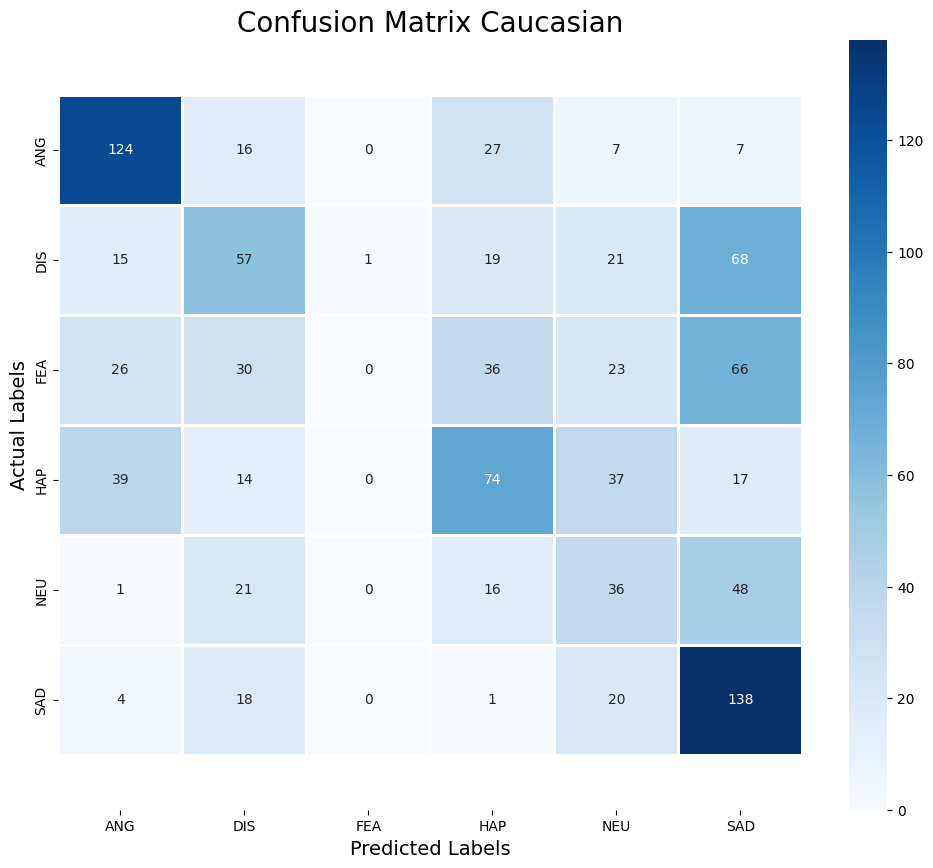

              precision    recall  f1-score   support

         ANG       0.59      0.69      0.64       181
         DIS       0.37      0.31      0.34       181
         FEA       0.00      0.00      0.00       181
         HAP       0.43      0.41      0.42       181
         NEU       0.25      0.30      0.27       122
         SAD       0.40      0.76      0.53       181

    accuracy                           0.42      1027
   macro avg       0.34      0.41      0.36      1027
weighted avg       0.34      0.42      0.37      1027



In [44]:
#CAUCASIAN CONFUSION MATRIX
actual = finaldf1['Actual Values'].loc[(finaldf1['race'] == 'Caucasian')]
predictions = finaldf1['Predicted Values'].loc[(finaldf1['race'] == 'Caucasian')]

cm = confusion_matrix(actual, predictions)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Confusion Matrix Caucasian', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.savefig('Initial_Model_Confusion_Matrix_cauc.png')
plt.show()

print(classification_report(actual, predictions, target_names = ['ANG','DIS','FEA','HAP','NEU','SAD']))

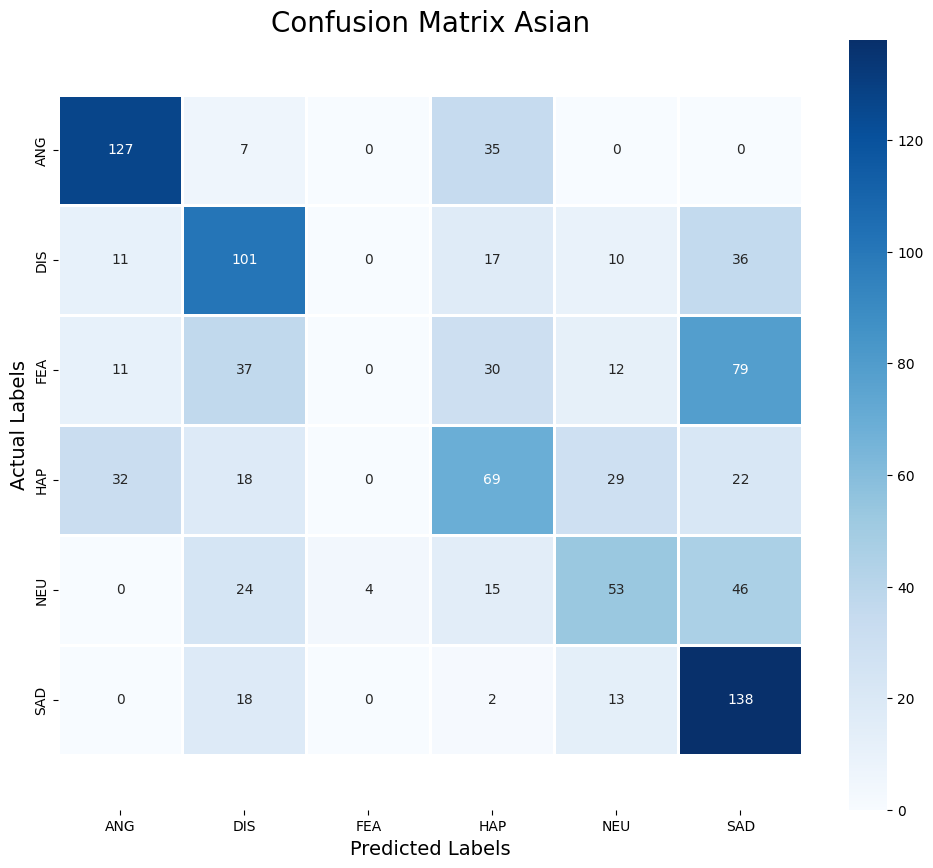

              precision    recall  f1-score   support

         ANG       0.70      0.75      0.73       169
         DIS       0.49      0.58      0.53       175
         FEA       0.00      0.00      0.00       169
         HAP       0.41      0.41      0.41       170
         NEU       0.45      0.37      0.41       142
         SAD       0.43      0.81      0.56       171

    accuracy                           0.49       996
   macro avg       0.41      0.49      0.44       996
weighted avg       0.41      0.49      0.44       996



In [45]:
#ASIAN CONFUSION MATRIX
actual = finaldf1['Actual Values'].loc[(finaldf1['race'] == 'Asian')]
predictions = finaldf1['Predicted Values'].loc[(finaldf1['race'] == 'Asian')]

cm = confusion_matrix(actual, predictions)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Confusion Matrix Asian', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.savefig('Initial_Model_Confusion_Matrix_as.png')
plt.show()

print(classification_report(actual, predictions, target_names = ['ANG','DIS','FEA','HAP','NEU','SAD']))

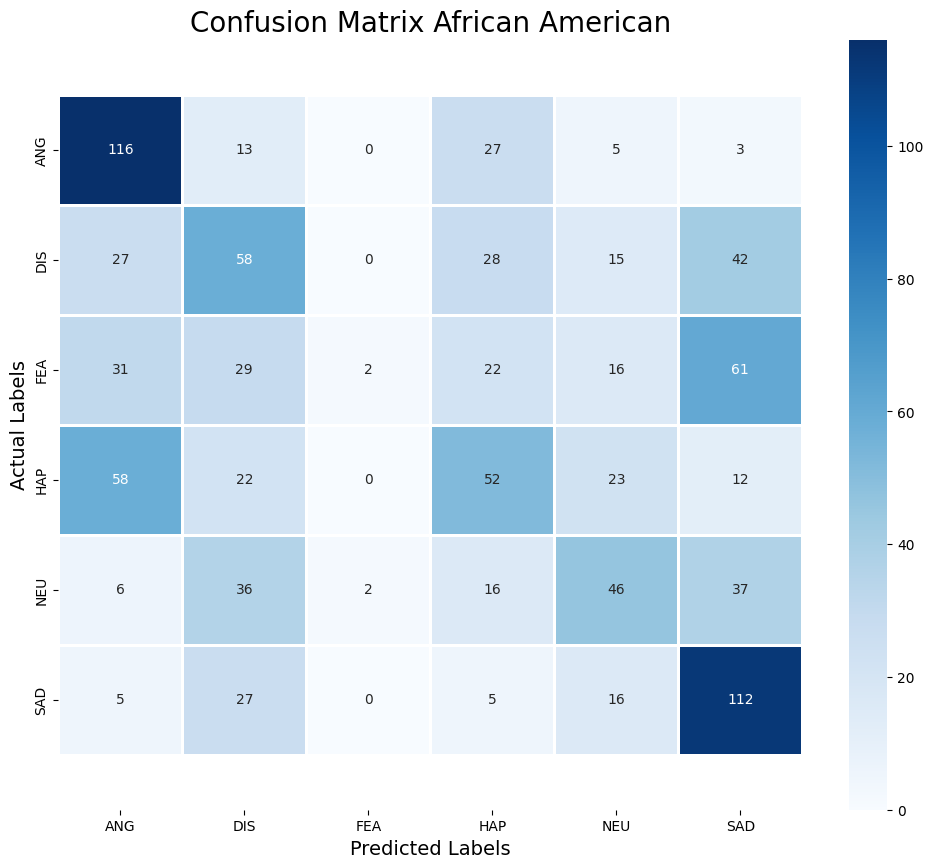

              precision    recall  f1-score   support

         ANG       0.48      0.71      0.57       164
         DIS       0.31      0.34      0.33       170
         FEA       0.50      0.01      0.02       161
         HAP       0.35      0.31      0.33       167
         NEU       0.38      0.32      0.35       143
         SAD       0.42      0.68      0.52       165

    accuracy                           0.40       970
   macro avg       0.41      0.40      0.35       970
weighted avg       0.41      0.40      0.35       970



In [46]:
#AFRICAN AMERICAN CONFUSION MATRIX
actual = finaldf1['Actual Values'].loc[(finaldf1['race'] == 'African American')]
predictions = finaldf1['Predicted Values'].loc[(finaldf1['race'] == 'African American')]

cm = confusion_matrix(actual, predictions)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Confusion Matrix African American', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.savefig('Initial_Model_Confusion_Matrix_af.png')
plt.show()

print(classification_report(actual, predictions, target_names = ['ANG','DIS','FEA','HAP','NEU','SAD']))

# Hyperparameter Tuning

In [47]:
# TRAIN TEST SPLIT DATA
train,test = train_test_split(df_combined, test_size=0.2, random_state=0,
                               stratify=df_combined[['race','actor']])

X_train = train.iloc[:, 3:]
y_train = train.iloc[:,:1]#.drop(columns=['gender'])
print(X_train.shape)

X_test = test.iloc[:,3:]
y_test = test.iloc[:,:1]#.drop(columns=['gender'])
print(X_test.shape)

(11971, 259)
(2993, 259)


In [48]:
# NORMALIZE DATA
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

In [49]:
# TURN DATA INTO ARRAYS FOR KERAS
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [50]:
# RESHAPE TO INCLUDE 3D TENSOR
X_train = X_train[:,:,np.newaxis]
X_test = X_test[:,:,np.newaxis]

In [51]:
from keras.utils import np_utils, to_categorical

lb = LabelEncoder()

y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [52]:
# CREATE FUNCTION FOR KERAS CLASSIFIER
opt = keras.optimizers.Adam(learning_rate=0.0001)
def make_classifier(optimizer=opt):
    #BUILD CNN MODEL
    print(X_train.shape)
    model = Sequential()
    model.add(layers.Conv1D(64, kernel_size=(10), activation='relu', input_shape=(X_train.shape[1],1)))
    model.add(layers.Conv1D(128, kernel_size=(10),activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
    model.add(layers.MaxPooling1D(pool_size=(8)))
    model.add(layers.Dropout(0.4))
    model.add(layers.Conv1D(128, kernel_size=(10),activation='relu'))
    model.add(layers.MaxPooling1D(pool_size=(8)))
    model.add(layers.Dropout(0.4))
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(6, activation='sigmoid'))
    opt = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
    return model


In [53]:
y_trainHot=np.argmax(y_train, axis=1)

In [54]:
# GRID SEARCH PARAMETERS TO FIND BEST VALUES
classifier = KerasClassifier(build_fn = make_classifier)
params = {
    'batch_size': [30, 36, 42],  #I changed [30, 32, 34] by [30, 36, 42] so that they are multiple of 6 (num_classes)
    'nb_epoch': [25, 50, 75, 100],  #I added 100
    'optimizer':['adam','SGD']}

grid_search = GridSearchCV(estimator=classifier,
                           param_grid=params,
                           scoring='accuracy',
                           cv=5)

grid_search = grid_search.fit(X_train,y_trainHot)

(11971, 259, 1)
75/75 [==============================] - 4s 56ms/step
(11971, 259, 1)
75/75 [==============================] - 3s 32ms/step
(11971, 259, 1)
75/75 [==============================] - 4s 50ms/step
(11971, 259, 1)
75/75 [==============================] - 3s 33ms/step
(11971, 259, 1)
75/75 [==============================] - 5s 60ms/step
(11971, 259, 1)
75/75 [==============================] - 3s 32ms/step
(11971, 259, 1)
75/75 [==============================] - 3s 43ms/step
(11971, 259, 1)
75/75 [==============================] - 3s 36ms/step
(11971, 259, 1)
75/75 [==============================] - 3s 33ms/step
(11971, 259, 1)
75/75 [==============================] - 3s 44ms/step
(11971, 259, 1)
75/75 [==============================] - 3s 32ms/step
(11971, 259, 1)
75/75 [==============================] - 4s 52ms/step
(11971, 259, 1)
75/75 [==============================] - 4s 54ms/step
(11971, 259, 1)
75/75 [==============================] - 3s 33ms/step
(11971, 259, 1)
75/7

In [ ]:
grid_search.best_params_

In [ ]:
grid_search.best_score_